In [1]:
import sys
import os
sys.path.append(os.path.abspath('../src'))
from data_processing.preprocessing import *

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from utils.plotting import *
from model.cnn import *
from model.gru import *
from model.lstm import *
from model.metrics import *
from model.unet import *

In [35]:
#import data
bnp_data = pd.read_csv("../gle.csv")
bnp_data.describe()

,Adj Close,Close,High,Low,Open,Volume,ma_close_5,ma_volume_5,ma_close_10,ma_volume_10
count,3844.000000,3844.000000,3844.000000,3844.000000,3844.000000,3.844000e+03,3844.000000,3.844000e+03,3844.000000,3.844000e+03
mean,394.980583,591.475262,596.885671,586.106107,591.570963,2.838604e+07,394.761198,2.838792e+07,394.481128,2.840139e+07
std,105.319275,102.450281,102.662743,102.541894,102.585100,1.535085e+07,104.882309,1.066455e+07,104.381369,9.379689e+06
min,218.505188,283.350006,286.850006,281.500000,286.000000,0.000000e+00,221.381573,3.094711e+06,227.685712,4.629016e+06
25%,312.676407,523.400024,530.350021,517.899765,524.800018,1.904675e+07,312.718340,2.150367e+07,312.921947,2.225508e+07
50%,362.836967,614.350006,619.250000,609.425018,614.450012,2.454633e+07,362.567886,2.628231e+07,362.467559,2.665554e+07
75%,468.338333,664.824997,670.324997,660.000000,665.225006,3.320791e+07,468.201440,3.280200e+07,468.516975,3.238581e+07
max,766.200012,796.000000,798.599976,790.500000,796.000000,1.769065e+08,760.480005,9.729327e+07,754.159998,9.683332e+07


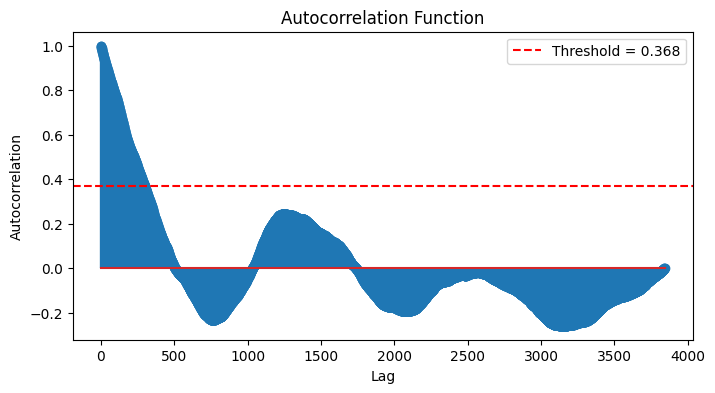

The autocorrelation radius is at lag: 299


In [3]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt

# Example DataFrame
# df = pd.DataFrame({'value': [your_time_series_data]})

# Compute the autocorrelation function
def calculate_autocorrelation_radius(df, column_name, threshold=1/np.e):
    """
    Calculate the autocorrelation radius of a time series.
    
    :param df: pandas DataFrame containing the time series
    :param column_name: Column name containing the time series values
    :param threshold: Threshold for the autocorrelation radius (default is 1/e)
    :return: Lag at which autocorrelation falls below the threshold
    """
    # Extract the time series
    series = df[column_name]

    # Calculate the autocorrelation function (ACF)
    acf_values = acf(series, fft=True, nlags=len(series) - 1)

    # Find the lag where ACF falls below the threshold
    radius_lag = next((lag for lag, value in enumerate(acf_values) if value < threshold), None)

    # Optional: Plot the ACF
    plt.figure(figsize=(8, 4))
    plt.stem(range(len(acf_values)), acf_values)
    plt.axhline(y=threshold, color='r', linestyle='--', label=f"Threshold = {threshold:.3f}")
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.title('Autocorrelation Function')
    plt.legend()
    plt.show()

    return radius_lag

# Example usage
radius = calculate_autocorrelation_radius(bnp_data, column_name='Adj Close')
print(f"The autocorrelation radius is at lag: {radius}")


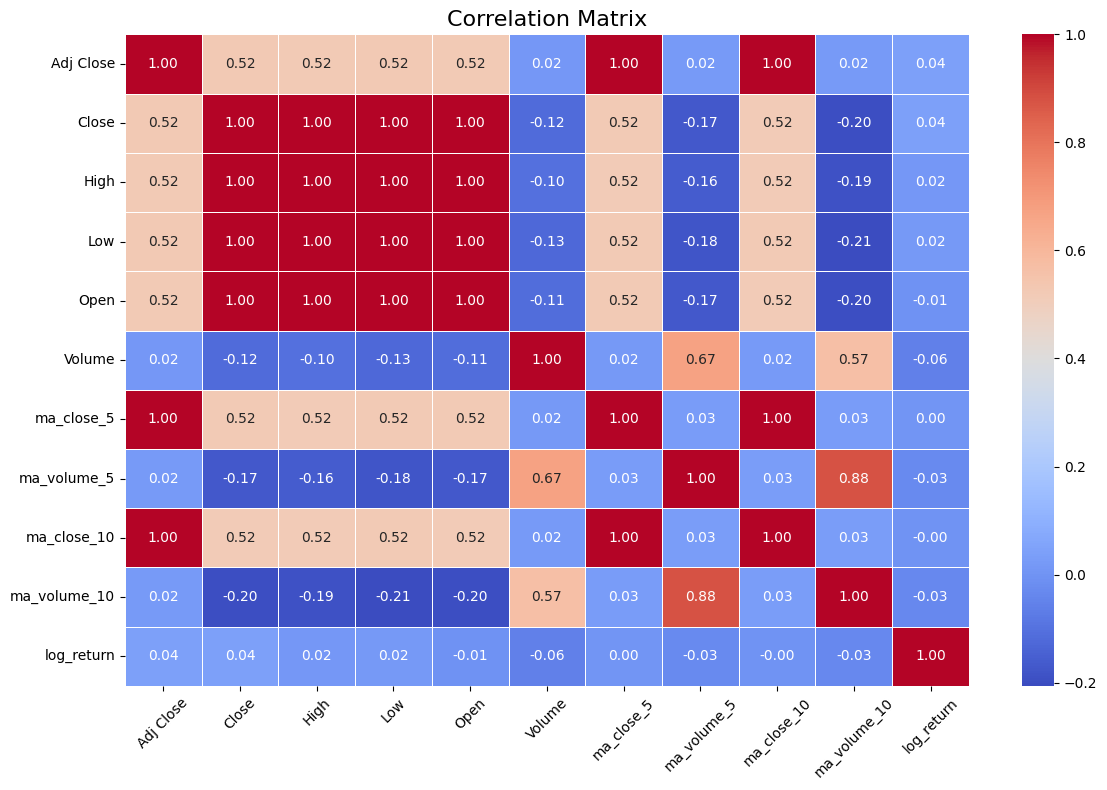

In [4]:
plot_correlation_matrix(bnp_data[bnp_data.columns[1:]])

In [8]:
features=['Adj Close', 'Close', 'Volume','log_return','ma_close_10','ma_volume_5']

In [6]:
gap = 600  # Gap between each subset

total_samples = len(bnp_data)
train_size = int(0.41 * total_samples)
test_size = int(0.135 * total_samples)
validation_size = int(0.135 * total_samples)

train,test,validation=data_splitting(bnp_data,train_size,test_size,validation_size,gap)

In [9]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Scaler for the target to inverse transform y_pred 
target = train[['Adj Close']]
scaler_target = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler_target.fit_transform(target)

# Scaler for the training dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train[features])
scaled_train = pd.DataFrame(scaled_train, columns=features)

# Applying the scaler of the training set onto test and validation set
scaled_test = scaler.transform(test[features])
scaled_test = pd.DataFrame(scaled_test, columns=features)

scaled_validation = scaler.transform(validation[features])
scaled_validation = pd.DataFrame(scaled_validation, columns=features)

<h2>LSTM Model</h2>

In [10]:
timesteps = 10
X_train, y_train = create_sequences(scaled_train, target_column='Adj Close', timesteps=timesteps)
X_test, y_test = create_sequences(scaled_test, target_column='Adj Close', timesteps=timesteps)
X_validation, y_validation = create_sequences(scaled_validation, target_column='Adj Close', timesteps=timesteps)

In [11]:
# Build and train the LSTM model
model = build_lstm_model((X_train.shape[1], X_train.shape[2]))  # Input shape (timesteps, features)
model.summary()

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',     # Monitors the validation loss
    patience=10,            # Number of epochs with no improvement after which training stops
    min_delta=0.001,        # Minimum improvement in loss to qualify as progress
    restore_best_weights=True  # Restores weights from the best epoch
)

# Learning Rate Scheduler
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,   # Reduce learning rate by half
    patience=5,   # Wait 5 epochs with no improvement
    min_lr=1e-6   # Minimum learning rate
)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test),callbacks=[early_stopping])


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 16)         │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 16)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,601 (14.07 KB)

 Trainable params: 3,601 (14.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.4735 - val_loss: 0.4911
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1718 - val_loss: 0.2169
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0886 - val_loss: 0.1927
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0515 - val_loss: 0.1302
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0380 - val_loss: 0.1025
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0288 - val_loss: 0.1008
Epoch 7/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0239 - val_loss: 0.1049
Epoch 8/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0211 - val_loss: 0.0904
Epoch 9/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0175 - val_loss: 0.0915
Epoch 10/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0180 - val_loss: 0.1243
Epoch 11/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0151 - val_loss: 0.1114
Epoch 12/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0138 - val_lo

In [12]:
# Predict and evaluate
y_pred = model.predict(X_test)
y_pred_rescaled = scaler_target.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = scaler_target.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
rmse = calculate_rmse(y_test_rescaled, y_pred_rescaled)
nse = calculate_nse(y_test_rescaled, y_pred_rescaled)

print(f"RMSE: {rmse:.4f}")
print(f"NSE: {nse:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
RMSE: 35.1020
NSE: 0.6426


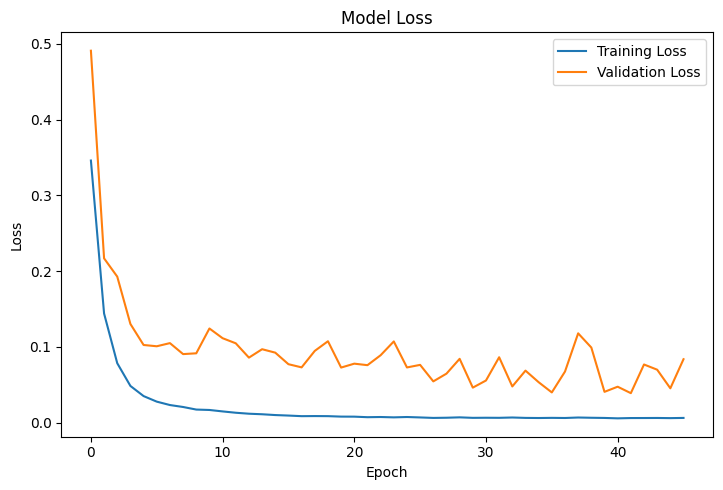

In [13]:
plot_learning_curves(history)

The gap between training and validation loss shows the model fits the training data too well but struggles to generalize.

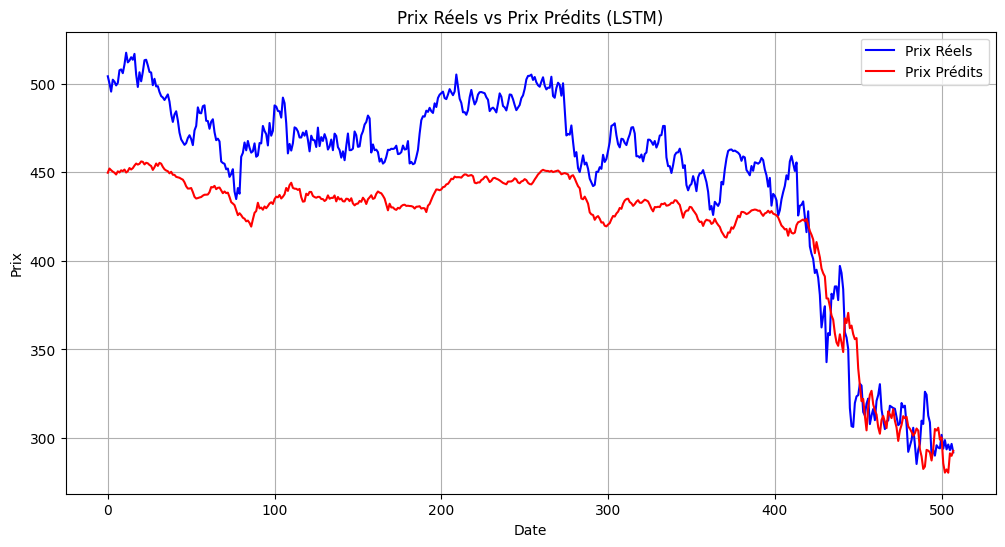

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Prix Réels', color='blue')
plt.plot(y_pred_rescaled, label='Prix Prédits', color='red')
plt.title("Prix Réels vs Prix Prédits (LSTM)")
plt.xlabel("Date")
plt.ylabel("Prix")
plt.legend()
plt.grid()
plt.show()

<h2> GRU Model</h2>

In [15]:
gru_model = build_gru_model((X_train.shape[1], X_train.shape[2]))
gru_model.summary()

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',     # Monitors the validation loss
    patience=10,            # Number of epochs with no improvement after which training stops
    min_delta=0.001,        # Minimum improvement in loss to qualify as progress
    restore_best_weights=True  # Restores weights from the best epoch
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 10, 16)         │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 16)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,801 (10.94 KB)

 Trainable params: 2,801 (10.94 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
gru_history = gru_model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test),callbacks=[early_stopping])

Epoch 1/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0892 - val_loss: 0.1458
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0386 - val_loss: 0.0784
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0287 - val_loss: 0.0546
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0239 - val_loss: 0.0498
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0203 - val_loss: 0.0375
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0177 - val_loss: 0.0205
Epoch 7/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0167 - val_loss: 0.0319
Epoch 8/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0140 - val_loss: 0.0246
Epoch 9/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0131 - val_loss: 0.0213
Epoch 10/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0126 - val_loss: 0.0195
Epoch 11/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0108 - val_loss: 0.0167
Epoch 12/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0101 - val_lo

In [17]:
# Predict and evaluate
y_pred = gru_model.predict(X_test)
y_pred_rescaled = scaler_target.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = scaler_target.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
rmse = calculate_rmse(y_test_rescaled, y_pred_rescaled)
nse = calculate_nse(y_test_rescaled, y_pred_rescaled)

print(f"RMSE: {rmse:.4f}")
print(f"NSE: {nse:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
RMSE: 7.6278
NSE: 0.9831


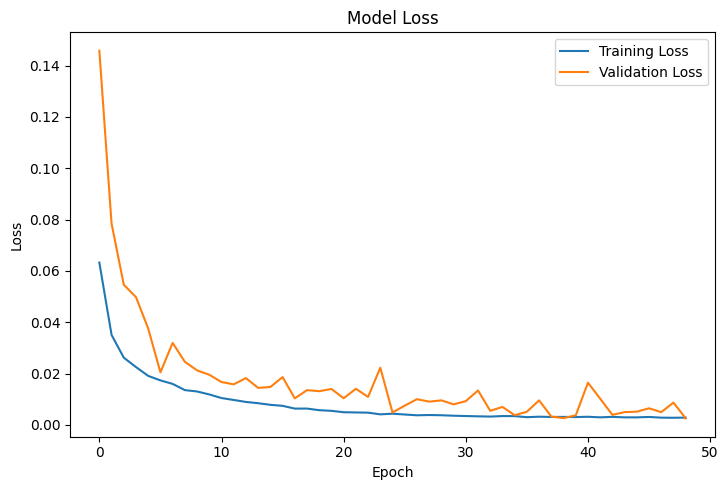

In [18]:
plot_learning_curves(gru_history)

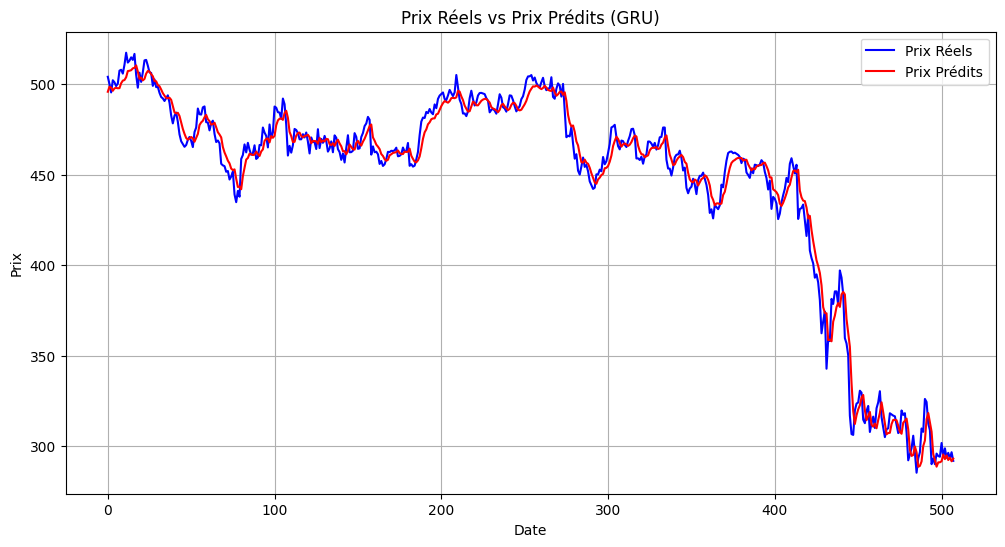

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Prix Réels', color='blue')
plt.plot(y_pred_rescaled, label='Prix Prédits', color='red')
plt.title("Prix Réels vs Prix Prédits (GRU)")
plt.xlabel("Date")
plt.ylabel("Prix")
plt.legend()
plt.grid()
plt.show()

<h2>CNN Model</h2>

In [20]:
cnn1d_model = build_cnn1d_model((X_train.shape[1], X_train.shape[2]))  
cnn1d_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 8, 64)          │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2, 64)          │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         3,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,869 (65.89 KB)

 Trainable params: 16,869 (65.89 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',     # Monitors the validation loss
    patience=10,            # Number of epochs with no improvement after which training stops
    min_delta=0.001,        # Minimum improvement in loss to qualify as progress
    restore_best_weights=True  # Restores weights from the best epoch
)

cnn1d_history = cnn1d_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0488 - val_loss: 0.1644
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0154 - val_loss: 0.1583
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0134 - val_loss: 0.1586
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0122 - val_loss: 0.1839
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0092 - val_loss: 0.1917
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0089 - val_loss: 0.1461
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0083 - val_loss: 0.2132
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0077 - val_loss: 0.2122
Epoch 9/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0068 - val_loss: 0.2036
Epoch 10/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0066 - val_loss: 0.2760
Epoch 11/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0071 - val_loss: 0.2030
Epoch 12/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0

In [22]:
# Predict and evaluate
y_pred = cnn1d_model.predict(X_test)
y_pred_rescaled = scaler_target.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = scaler_target.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
rmse = calculate_rmse(y_test_rescaled, y_pred_rescaled)
nse = calculate_nse(y_test_rescaled, y_pred_rescaled)

print(f"RMSE: {rmse:.4f}")
print(f"NSE: {nse:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
RMSE: 67.3731
NSE: -0.3165


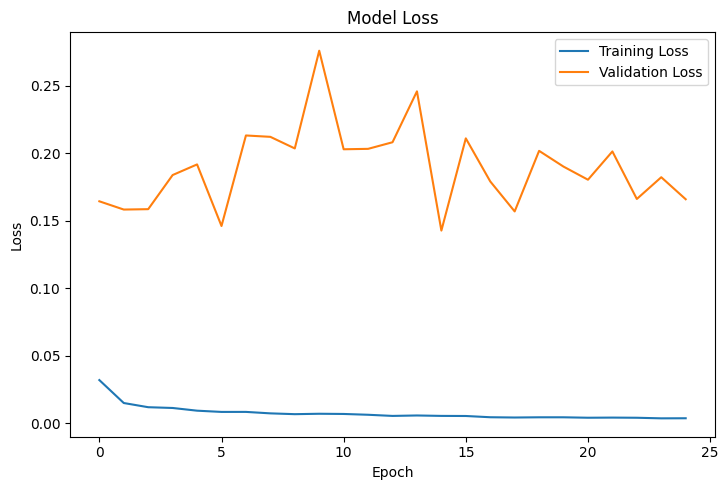

In [23]:
plot_learning_curves(cnn1d_history)

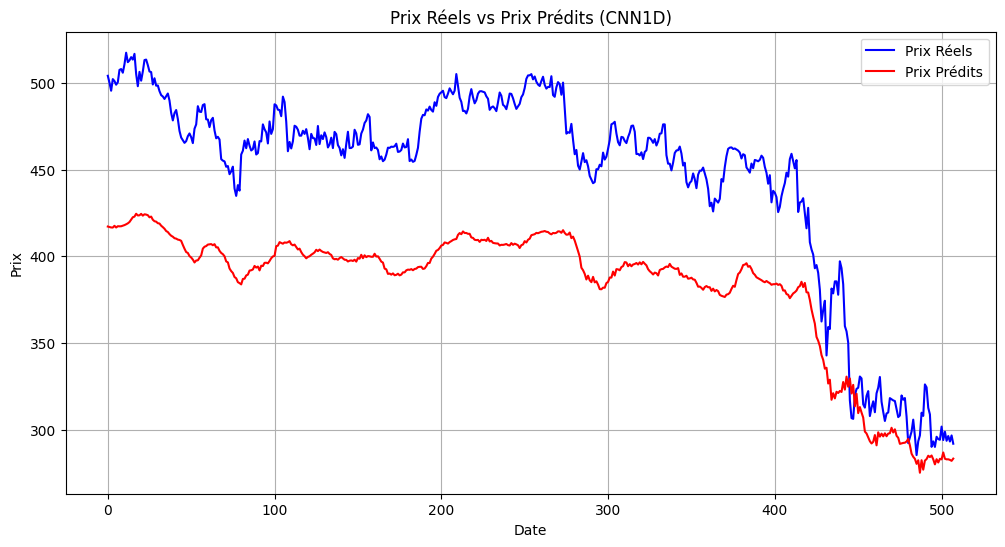

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Prix Réels', color='blue')
plt.plot(y_pred_rescaled, label='Prix Prédits', color='red')
plt.title("Prix Réels vs Prix Prédits (CNN1D)")
plt.xlabel("Date")
plt.ylabel("Prix")
plt.legend()
plt.grid()
plt.show()

<h2>Deeper CNN</h2>

In [25]:
cnndeep_model = build_cnn1d_deep_model((X_train.shape[1], X_train.shape[2]))  
cnndeep_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 10, 128)        │         3,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 10, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 5, 128)         │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 5, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 2, 64)          │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 2, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        12,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,169 (360.04 KB)

 Trainable params: 91,529 (357.54 KB)

 Non-trainable params: 640 (2.50 KB)

In [26]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',     # Monitors the validation loss
    patience=10,            # Number of epochs with no improvement after which training stops
    restore_best_weights=True  # Restores weights from the best epoch
)

cnndepp_history = cnndeep_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3256 - val_loss: 1.0845
Epoch 2/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0595 - val_loss: 1.0428
Epoch 3/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0293 - val_loss: 0.8612
Epoch 4/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0232 - val_loss: 0.6699
Epoch 5/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0197 - val_loss: 0.4367
Epoch 6/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0186 - val_loss: 0.2585
Epoch 7/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0144 - val_loss: 0.0867
Epoch 8/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0139 - val_loss: 0.1522
Epoch 9/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0142 - val_loss: 0.1600
Epoch 10/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0112 - val_loss: 0.0823
Epoch 11/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0126 - val_loss: 0.1160
Epoch 12/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0

In [27]:
# Predict and evaluate
y_pred = cnndeep_model.predict(X_test)
y_pred_rescaled = scaler_target.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = scaler_target.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
rmse = calculate_rmse(y_test_rescaled, y_pred_rescaled)
nse = calculate_nse(y_test_rescaled, y_pred_rescaled)

print(f"RMSE: {rmse:.4f}")
print(f"NSE: {nse:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
RMSE: 28.5664
NSE: 0.7633


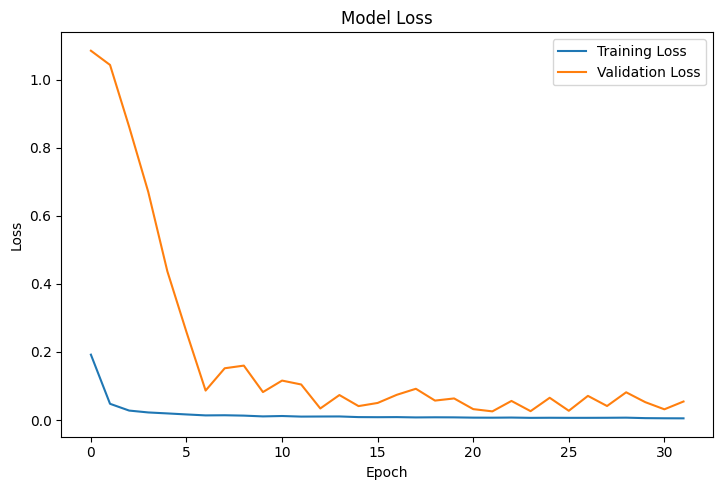

In [28]:
plot_learning_curves(cnndepp_history)

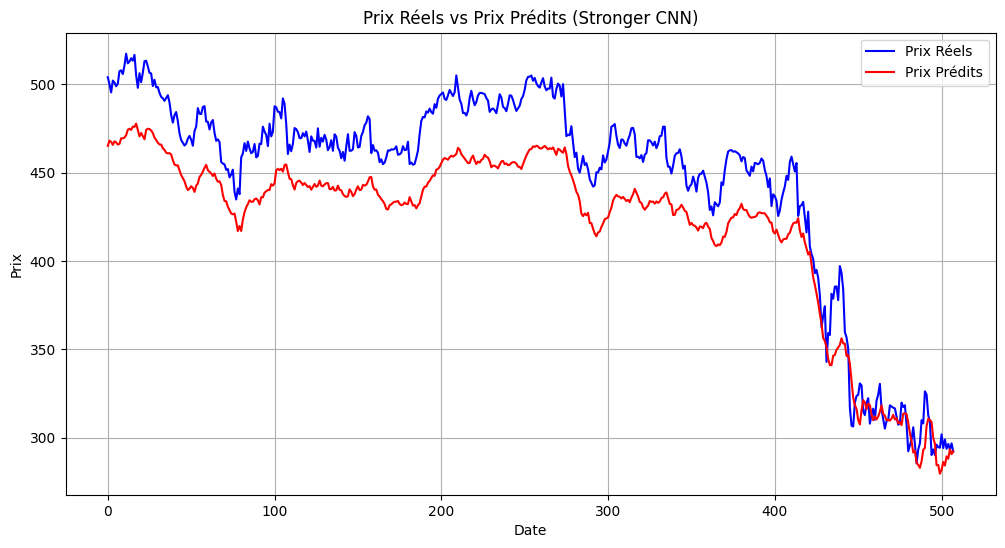

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Prix Réels', color='blue')
plt.plot(y_pred_rescaled, label='Prix Prédits', color='red')
plt.title("Prix Réels vs Prix Prédits (Stronger CNN)")
plt.xlabel("Date")
plt.ylabel("Prix")
plt.legend()
plt.grid()
plt.show()

<h2>Stronger CNN</h2>

In [30]:
lstmcnn_model = build_lstm_cnn_model((X_train.shape[1], X_train.shape[2]))  
lstmcnn_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)               │ (None, 10, 64)         │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 5, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,745 (186.50 KB)

 Trainable params: 47,745 (186.50 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',     # Monitors the validation loss
    patience=10,            # Number of epochs with no improvement after which training stops
    restore_best_weights=True  # Restores weights from the best epoch
)

lstmcnn_history = lstmcnn_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.2992 - val_loss: 0.2968
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1101 - val_loss: 0.1353
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0679 - val_loss: 0.1319
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0484 - val_loss: 0.0938
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0373 - val_loss: 0.0687
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0335 - val_loss: 0.1170
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0265 - val_loss: 0.0974
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0245 - val_loss: 0.0812
Epoch 9/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0213 - val_loss: 0.0734
Epoch 10/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0192 - val_loss: 0.0706
Epoch 11/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0176 - val_loss: 0.0978
Epoch 12/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.

In [32]:
# Predict and evaluate
y_pred = lstmcnn_model.predict(X_test)
y_pred_rescaled = scaler_target.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = scaler_target.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
rmse = calculate_rmse(y_test_rescaled, y_pred_rescaled)
nse = calculate_nse(y_test_rescaled, y_pred_rescaled)

print(f"RMSE: {rmse:.4f}")
print(f"NSE: {nse:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
RMSE: 33.2884
NSE: 0.6786


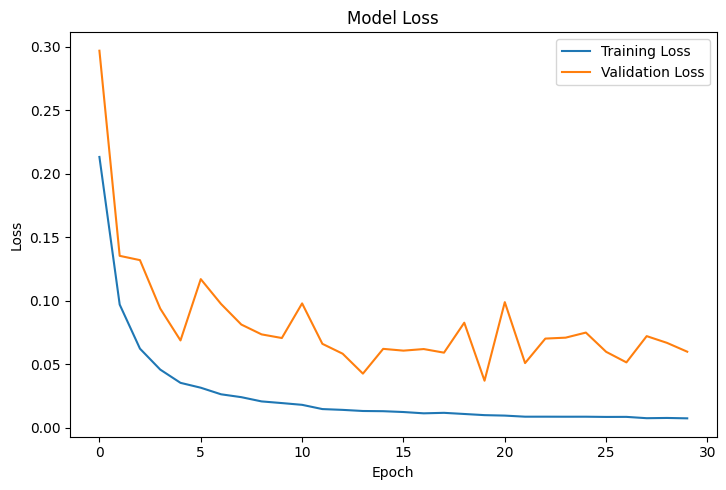

In [33]:
plot_learning_curves(lstmcnn_history)

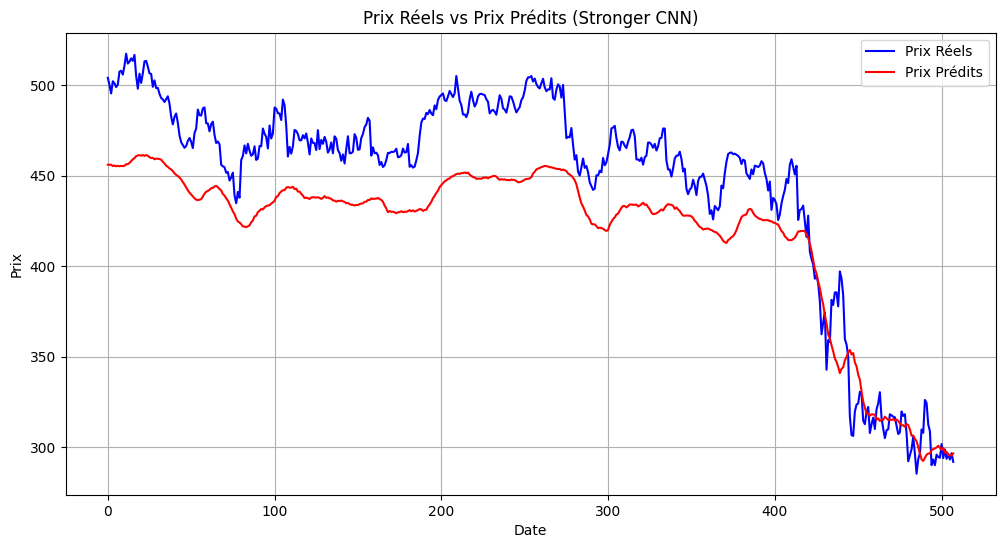

In [34]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Prix Réels', color='blue')
plt.plot(y_pred_rescaled, label='Prix Prédits', color='red')
plt.title("Prix Réels vs Prix Prédits (Stronger CNN)")
plt.xlabel("Date")
plt.ylabel("Prix")
plt.legend()
plt.grid()
plt.show()

<h2>Performance comparison with a y[t]=y[t-1] model</h2>

In [32]:
import numpy as np
import pandas as pd

def create_shifted_timeseries(x):
    """
    Create a time series y from x such that:
        y[t] = x[t-1] for t > 0
        y[0] = x[0]
        
    Parameters:
        x (array-like): The input time series.
        
    Returns:
        y (np.ndarray): The shifted time series.
    """
    y = np.zeros_like(x)  # Initialize y with the same shape as x
    y[0] = x[0]           # Set the first value of y to the first value of x
    y[1:] = x[:-1]        # Set y[t] = x[t-1] for t > 0
    return y

y_pred=create_shifted_timeseries(y_test)
y_pred_rescaled = scaler_target.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = scaler_target.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
rmse = calculate_rmse(y_test_rescaled, y_pred_rescaled)
nse = calculate_nse(y_test_rescaled, y_pred_rescaled)

print(f"RMSE: {rmse:.4f}")
print(f"NSE: {nse:.4f}")

RMSE: 0.8728
NSE: 0.9904


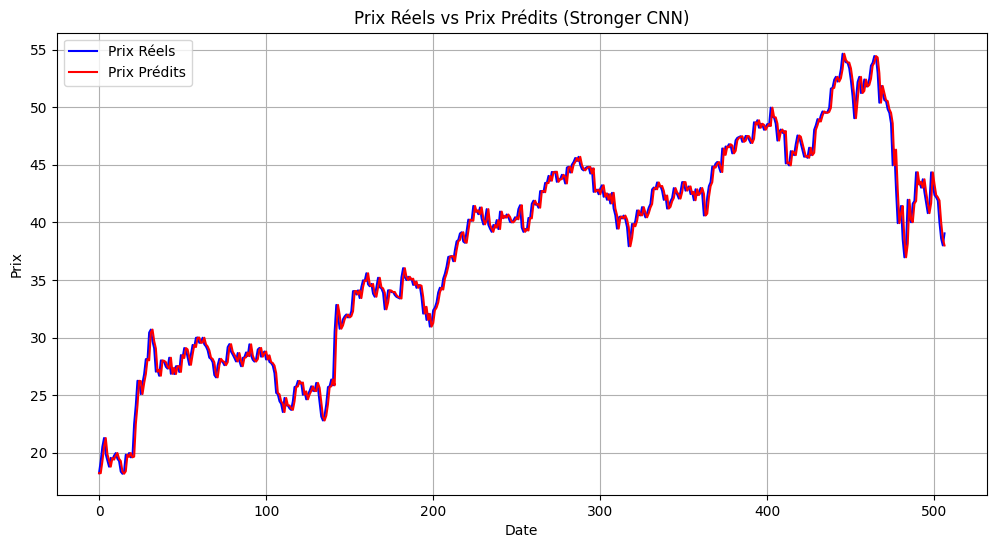

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Prix Réels', color='blue')
plt.plot(y_pred_rescaled, label='Prix Prédits', color='red')
plt.title("Prix Réels vs Prix Prédits (Stronger CNN)")
plt.xlabel("Date")
plt.ylabel("Prix")
plt.legend()
plt.grid()
plt.show()